# Image classification: CIFAR-10

## Introduction
This tutorial demonstrates end-to-end image classification on Loihi from training to inference. We first train a conventional ANN using Tensorflow/Keras, convert it to an SNN using the [SNN-Toolbox](https://snntoolbox.readthedocs.io/en/latest/), map it to Loihi using NxTF and finally perform inference.

For training, we setup an ANN in Keras and train it in Tensorflow:
<img src="figures/1_training.png" width=600 height=600>

To convert the trained ANN into an SNN we use the SNN-Toolbox. 
Generally, the SNN-TB is able to parse and interpret ANNs from different frameworks such as Keras, Cafe, ... and to convert it via different backend into SNNs for different simulation or execution platforms. The Loihi-backend is only availabe as part of the NxSDK in the INRC.

During conversion, the Loihi backend primarily quantizes the floating point weights and biases of the ANN into integer weights and biases and suitable thresholds of the corresponding SNN with the objective to maximize the correlation between the ANN activations and SNN spike rates.

Finally, the SNN-TB finally uses NxTF to compile the SNN. Since compilation can be quite time consuming (at the moment due to missing optimizations in the DNN compiler) NxTF/SNN-TB automatically stores the compiled SNN as well as other collateral compiler information to disk for faster execution later on.
<img src="figures/2_conversion.png" width=600 height=600>
Besides converting an ANN to SNN, the SNN-TB will automatically perform classification given a model and testing data. However, data IO handling is not optimized within the SNN-TB backend for Loihi at the moment and thus will be comparatively slow. It is thus recommended to only use the SNN-TB for conversion, but then to proceed and connect the resulting SNN with the InputGenerator provided by NxSDK.

For faster image classification, we first load the compiled model and wrap the SNN by a "ComposableSNN" class. This is merely a container that provides the necessary interfaces for connecting different independent models with each other. We will integrate these composability features with the NxModel class soon which makes this wrapper obsolete.

Next we connect the already composable InputGenerator with the ComposableSNN and compile the resulting model. During this process the compiler only needs to compile the InputGenerator but reuse the previous compiler collateral information which allows for fast experimentation without having to alwasy recompile the SNN from scratch.
<img src="figures/3_setup.png" width=600 height=600>
Note that changing weights curently still requires to recompile the SNN even if the model topology has not changed.

Finally, the compiled model can be executed on Loihi to classify the test set.
<img src="figures/4_inference.png" width=600 height=600>

## Setup

In [6]:
import matplotlib
matplotlib.use("Agg")
from nxsdk.logutils.nxlogging import set_verbosity, LoggingLevel

set_verbosity(LoggingLevel.ERROR)

In [7]:
import os
import sys

# Define working directory in which trained ANN and converted SNN get stored
WORKING_DIR = os.path.join(os.path.expanduser("~"),
                           "projects",
                           "image_classification_pseudo_mobile_net")
os.system("mkdir -p {}".format(WORKING_DIR))

os.environ['SLURM'] = '1'
# os.environ['PYTHONUNBUFFERED'] = '1'
os.environ['PARTITION'] = 'nahuku32'

sys.path.insert(0, "/homes/biagiom/intel-nrc-models")

## 1. ANN training
For training an ANN for image classifiaction, we use the module provided in:

/dnn/utils/train_pseudo_mobile_net.py

This module sets up a DNN that is inspired by a MobileNet architecture and consists of a variable number of blocks of pairs of depth-wise separable convolutions and 1x1 point-wise convolutions. This model is then trained on the CIFAR-10 dataset.

This model is not yet particularly optimized for Loihi so please feel free to keep optimizing. We generally recommend using depth-wise separable convolutions in order to maximize resource utilization on Loihi. In addition, it is advisable to use some form of weight/bias regularization during training in order to prevent too much divergence of the parameter distribution during training as this can lead to information loss upon quantization via the SNN-TB.

In [8]:
from nxsdk_modules_ncl.dnn.utils.train_pseudo_mobile_net import Parameters, gen_model_checkpoint_dir, get_dataset, train_model
from keras.datasets import cifar10

Define parameters for training

In [9]:
p = Parameters(input_shape=(32, 32, 3),
               batch_size=64,
               num_epochs=400,
               num_classes=10,
               alpha=0.5,
               num_blocks=2,
               max_num_training_samples=50000,
               weight_regularizer=1e-4,
               dropout=2**-6,
               use_bias=False,
               pretrained_model_path=None,
               max_value=None,
               signed_input=False,
               working_dir=WORKING_DIR)

Load normalized training and test set for CIFAR-10

In [10]:
x_train, y_train, x_test, y_test = get_dataset(cifar10, p)

Please do NOT run the training module on your Intel-provided virtual environment! The following cell is just for illustration purposes. Your virtual environment runs on a shared resource with limited compute power. Instead please train the model on your own CPU or GPU.

In [11]:
if False:
    assert False, "DON'T run on Intel virtual machine."
    # Generate checkpoint directory (does not overwrite existing directory)
    mcd = gen_model_checkpoint_dir(p.working_dir, run_ctr=0, run_name="test")
    
    # Train model
    train_model(p, x_train, y_train, x_test, y_test,
                model_checkpoints_dir=mcd)

To continue with this tutorial, use the following ANN which was pre-trained on CIFAR-10 up to 87% in:
/dnn/models/pseudo-mobile_net_0.87.h5 

Alternatively change the path to your own trained model.

In [12]:
MODEL_NAME = 'b_cifar_pseudo_mobile_net_0.87'
ANN_MODEL_PATH = os.path.join(os.path.abspath(''), 'models', MODEL_NAME+'.h5') 
print(ANN_MODEL_PATH)

/homes/biagiom/intel-nrc-models/nxsdk_modules_ncl/dnn/tutorials/models/b_cifar_pseudo_mobile_net_0.87.h5


## 2. ANN to SNN conversion

### SNN-TB configuration

Configuration parameters

In [13]:
num_steps_per_sample = 512
num_test_samples     = 100
reset_mode           = 'soft'
num_cores_per_chip   = 128

# Set to False by default to bypass conversion and use previously converted SNN
CONVERT_MODEL = True

The SNN-TB requires the validation set to be present in DATASET_DIR directory.

In [14]:
DATASET_DIR = os.path.join("/", "nfs", "ncl", "datasets", "CIFAR10")

The SNN-TB expects to find the ANN model to convert in same working directory where it also dumps its own output. 
Therefore we copy the ANN to the user's working directory.

In [15]:
os.system("cp {} {}".format(ANN_MODEL_PATH, WORKING_DIR))

0

### Helper functions

In [16]:
def gen_config_file(reset_mode='soft', max_num_cores_per_chip=128,
                    num_test_samples=1, duration=512):
    """Generates a SNN-TB config file to convert a pre-trained ANN into an SNN.

    :returns Path to generated SNN-TB config file.
    """
   
    # Define configuration for ANN to SNN conversion
    import configparser
    config = configparser.ConfigParser()

    config['paths'] = {
        'path_wd': WORKING_DIR,                        # Path where log get stored and where ANN is expected
        'dataset_path': DATASET_DIR,                   # Path to data set
        'filename_ann': MODEL_NAME,                    # Name of model .h5 file in path_wd
        'runlabel': "_".join([MODEL_NAME, reset_mode]) # Name of directory where results of a single run get stored
    }

    config['tools'] = {
        'evaluate_ann': True, # Test ANN on dataset before conversion
        'parse': True,        # Parses input model
        'normalize': False    # Not needed for Loihi backend -> Do we need that?
    }

    config['simulation'] = {
        'simulator': 'loihi',            # Selects Loihi as backend of SNN-TB
        'duration': duration,            # Number of time steps to run each sample
        'num_to_test': num_test_samples, # How many samples to run
        'batch_size': 1,                 # Batch size 1 is the only supported value for Loihi backend
        'keras_backend': 'tensorflow'}

    config['restrictions'] = {
        'spiking_layers': {'Dense', 'Conv2D', 'MaxPooling2D', 'AveragePooling2D', 'DepthwiseConv2D'} # Currently supported layers
    }

    config['loihi'] = {
        'validate_partitions': False,  # Validates correctness of compiled layers
        'save_output': False,          # Plots compiler information
        'use_reset_snip': True,        # Using snip accelerates reset between samples
        'do_overflow_estimate': True,  # Estimate overflow of dendritic accumulator.
        'normalize_thresholds': True,  # Tune thresholds to optimal dynamic range.
        'desired_threshold_to_input_ratio': 2**3 if reset_mode == 'hard' else 1,           # Scaling factor between max input and threshold
        'compartment_kwargs': {'biasExp': 6, 'vThMant': 512},                              # Arguments passed to NxTF layer
        'connection_kwargs': {'numWeightBits': 8, 'weightExponent': 0, 'numBiasBits': 12}, # Arguments passed to NxTF layer
        'reset_mode': reset_mode,                      # reset_mode can be 'soft'/'hard' for reset-by-subtraction (more accurate) or reset-to-zero
        'num_cores_per_chip': max_num_cores_per_chip,  # Limites the maximum number of usale cores per chip
        'saturation': 6,                               # Saturation level of ReLU function used in ANN
        'plot_histograms': False,                      # Create histrams of weights/biases of converted SNN
    }

    # Generate config file
    config_filepath = os.path.join(WORKING_DIR, 'config')
    with open(config_filepath, 'w') as configfile:
        config.write(configfile)

    return config_filepath

In [17]:
def convert_model(config_file_path):
    """Converts ANN into SNN given configuration in <config_file_path>."""

    from snntoolbox.bin.run import main

    main(config_file_path)

### Convert ANN to SNN using SNN-TB
Generate SNN-TB config file and convert ANN based on these settings. The SNN-TB stores the config file in WORKING_DIR and it also dumps the compiler colateral information in /WORKING_DIR/log/gui/MODEL_NAME_<reset_mode> which allows to reload the model from disc later.

Note: The SNN-TB creates a set of directories within /WORKING_DIR/log/gui/MODEL_NAME_<reset_mode>/model_dumps/ to which it directs collateral information from the NxTF compiler that allows the compilation either to resume from an earlier point or load a pre-compiled model.

In [18]:
if CONVERT_MODEL:
    config_file_path = gen_config_file(
        reset_mode=reset_mode,
        max_num_cores_per_chip=num_cores_per_chip,
        num_test_samples=num_test_samples,
        duration=num_steps_per_sample
    )
    
    convert_model(config_file_path)

Initializing loihi simulator...

Loading data set from '.npz' files in /nfs/ncl/datasets/CIFAR10.

Evaluating input model on 100 samples...
Top-1 accuracy: 86.00%
Top-5 accuracy: 99.00%

Parsing input model...
Skipping layer InputLayer.
Parsing layer Conv2D.
Using activation relu.
Absorbing batch-normalization parameters into parameters of previous Conv2D.
Using BatchNorm axis 3.
Skipping layer BatchNormalization.
Skipping layer Activation.
Skipping layer Dropout.
Parsing layer DepthwiseConv2D.
Using activation relu.
Absorbing batch-normalization parameters into parameters of previous DepthwiseConv2D.
Using BatchNorm axis 3.
Skipping layer BatchNormalization.
Skipping layer Activation.
Parsing layer Conv2D.
Using activation relu.
Absorbing batch-normalization parameters into parameters of previous Conv2D.
Using BatchNorm axis 3.
Skipping layer BatchNormalization.
Skipping layer Activation.
Skipping layer Dropout.
Parsing layer DepthwiseConv2D.
Using activation relu.
Absorbing batch-nor

Building layer: 01DepthwiseConv2D_16x16x32
Building layer: 02Conv2D_16x16x64
Building layer: 03DepthwiseConv2D_8x8x64
Building layer: 04Conv2D_8x8x128
Building layer: 05DepthwiseConv2D_8x8x128
Building layer: 06Conv2D_8x8x128
Building layer: 07DepthwiseConv2D_4x4x128
In the worst case of all pre-synaptic neurons firing simultaneously, the dendritic accumulator will overflow in 100.00% and underflow in 0.00% of neurons.
Estimating averages...
On average, the dendritic accumulator will overflow in 100.00 +/- 0.00 % and underflow in 0.00 +/- 0.00 % of neurons.
Building layer: 08Conv2D_4x4x256
Building layer: 09DepthwiseConv2D_4x4x256
Building layer: 10Conv2D_4x4x256
Building layer: 11AveragePooling2D_2x2x256
In the worst case of all pre-synaptic neurons firing simultaneously, the dendritic accumulator will overflow in 100.00% and underflow in 0.00% of neurons.
Estimating averages...
On average, the dendritic accumulator will overflow in 100.00 +/- 0.00 % and underflow in 0.00 +/- 0.00 % o


Starting new simulation...

Setting inputs...spikes... . 
Done setting inputs.
    Processing timeseries... 

Batch 13 of 100 completed (13.0%)
Moving accuracy of SNN (top-1, top-1): 92.31%, 92.31%.
Moving accuracy of ANN (top-1, top-1): 92.31%, 100.00%.


Starting new simulation...

Setting inputs...spikes... . 
Done setting inputs.
    Processing timeseries... 

Batch 14 of 100 completed (14.0%)
Moving accuracy of SNN (top-1, top-1): 92.86%, 92.86%.
Moving accuracy of ANN (top-1, top-1): 92.86%, 100.00%.


Starting new simulation...

Setting inputs...spikes... . 
Done setting inputs.
    Processing timeseries... 

Batch 15 of 100 completed (15.0%)
Moving accuracy of SNN (top-1, top-1): 93.33%, 93.33%.
Moving accuracy of ANN (top-1, top-1): 93.33%, 100.00%.


Starting new simulation...

Setting inputs...spikes... . 
Done setting inputs.
    Processing timeseries... 

Batch 16 of 100 completed (16.0%)
Moving accuracy of SNN (top-1, top-1): 93.75%, 93.75%.
Moving accuracy of ANN (top-1

    Processing timeseries... 

Batch 42 of 100 completed (42.0%)
Moving accuracy of SNN (top-1, top-1): 83.33%, 83.33%.
Moving accuracy of ANN (top-1, top-1): 88.10%, 97.62%.


Starting new simulation...

Setting inputs...spikes... . 
Done setting inputs.
    Processing timeseries... 

Batch 43 of 100 completed (43.0%)
Moving accuracy of SNN (top-1, top-1): 83.72%, 83.72%.
Moving accuracy of ANN (top-1, top-1): 88.37%, 97.67%.


Starting new simulation...

Setting inputs...spikes... . 
Done setting inputs.
    Processing timeseries... 

Batch 44 of 100 completed (44.0%)
Moving accuracy of SNN (top-1, top-1): 84.09%, 84.09%.
Moving accuracy of ANN (top-1, top-1): 88.64%, 97.73%.


Starting new simulation...

Setting inputs...spikes... . 
Done setting inputs.
    Processing timeseries... 

Batch 45 of 100 completed (45.0%)
Moving accuracy of SNN (top-1, top-1): 84.44%, 84.44%.
Moving accuracy of ANN (top-1, top-1): 88.89%, 97.78%.


Starting new simulation...

Setting inputs...spikes... 


Starting new simulation...

Setting inputs...spikes... . 
Done setting inputs.
    Processing timeseries... 

Batch 72 of 100 completed (72.0%)
Moving accuracy of SNN (top-1, top-1): 79.17%, 79.17%.
Moving accuracy of ANN (top-1, top-1): 83.33%, 98.61%.


Starting new simulation...

Setting inputs...spikes... . 
Done setting inputs.
    Processing timeseries... 

Batch 73 of 100 completed (73.0%)
Moving accuracy of SNN (top-1, top-1): 79.45%, 79.45%.
Moving accuracy of ANN (top-1, top-1): 83.56%, 98.63%.


Starting new simulation...

Setting inputs...spikes... . 
Done setting inputs.
    Processing timeseries... 

Batch 74 of 100 completed (74.0%)
Moving accuracy of SNN (top-1, top-1): 79.73%, 79.73%.
Moving accuracy of ANN (top-1, top-1): 83.78%, 98.65%.


Starting new simulation...

Setting inputs...spikes... . 
Done setting inputs.
    Processing timeseries... 

Batch 75 of 100 completed (75.0%)
Moving accuracy of SNN (top-1, top-1): 80.00%, 80.00%.
Moving accuracy of ANN (top-1, t

## 3. Model setup

In [19]:
import numpy as np    

In [20]:
def build_snn_from_file(snntb_log_dir, num_steps_per_img):
    """Loads converted SNN from file and builds composable DNN with InputGenerator.
    
    :param snntb_log_dir: Log directory within WORKING_DIR that SNN-TB creates.
    :param num_step_per_img: Number of time steps a single sample is presented.

    :returns Model with InputGenerator and SNN
    """

    from nxsdk_modules_ncl.dnn.src.dnn_layers import loadNxModel
    from nxsdk_modules_ncl.dnn.composable.composable_dnn import ComposableDNN as CDNN
    from nxsdk_modules.input_generator.input_generator import InputGenerator
    from nxsdk.composable.model import Model

    # Define directory from which to load compiled SNN
    abs_log_dir = os.path.join(WORKING_DIR, 'log', 'gui', snntb_log_dir)
    model_path = os.path.join(abs_log_dir, 'model_dumps', 'runnables', 'nxModel.h5')
    
    # Load SNN from file
    snn_model = loadNxModel(
        filepath=model_path,
        customObjects=None,
        logdir=abs_log_dir)

    # Wrap loaded SNN by ComposableDNN class that allows to connect the SNN to input generator
    # (Wrapper won't be necessary anymore in future)
    # ComposalbeDNN needs num_steps_per_image because the readout snip and activity reset snip are executed 
    # periodically after each sample
    cdnn = CDNN(model=snn_model, num_steps_per_img=num_steps_per_img)

    # Configure input generator to stream images via channels from super host to Loihi
    input_generator = InputGenerator(shape=snn_model.layers[0].input_shape,
                                     interval=num_steps_per_img,
                                     numSnipsPerChip=3)
    
    cdnn.name = "dnn"
    input_generator.name = "input"

    input_generator.setBiasExp(6)

    # All all components to parent model and connect input generator to SNN.
    model = Model('dnn')
    model.add(cdnn)
    model.add(input_generator)
    input_generator.connect(cdnn)
    # Enforce ordering of input and reset snip. The reset must execute before new input is injected.
    input_generator.processes.inputEncoder.executeAfter(cdnn.processes.reset)

    model.compile()

    return model

In [21]:
def run_model(model, num_steps_per_sample, x_test, y_test):
    """Runs the SNN Model to classify test images."""

    import time
    
    num_samples = len(y_test)

    # Start DNN
    tStart = time.time()
    model.start(model.board)
    model.run(num_steps_per_sample * num_samples, aSync=True)
    tEndBoot = time.time()

    # Enqueue images by pushing them into InputGenerator
    print("Sending images...")    
    labels = np.zeros(num_samples, int)
    for i, (x, y) in enumerate(zip((x_test * 255).astype(int), y_test)):
        if len(x.shape) < 4:
            x = np.expand_dims(x, 0)
        model.composables.input.encode(x)
        labels[i] = np.argmax(y)
    tEndInput = time.time()

    # Read out classification results for all images
    print("Waiting for classification to finish...")
    classifications = list(model.composables.dnn.readout_channel.read(num_samples))
    tEndClassification = time.time()

    # finishRun fetches EnergyProbe data if configured
    model.finishRun()
    
    dt_boot = tEndBoot - tStart
    dt_input = tEndInput - tEndBoot
    dt_classification = tEndClassification - tEndBoot

    return (dt_boot, dt_input, dt_classification), classifications, labels

In [22]:
def calc_accuracy(classifications, labels):
    """Calculates classification accuracy for a set of images given classification and labels."""

    errors = classifications != labels
    num_errors = np.sum(errors)
    num_samples = len(classifications)
    return (num_samples - num_errors) / num_samples

## 4. Inference

### Build model

In [23]:
print(reset_mode)
print(MODEL_NAME)
print(WORKING_DIR)

soft
b_cifar_pseudo_mobile_net_0.87
/homes/biagiom/projects/image_classification_pseudo_mobile_net


In [24]:
os.environ["SLURM"] = "1"
model = build_snn_from_file(snntb_log_dir=MODEL_NAME+"_"+reset_mode,
                            num_steps_per_img=num_steps_per_sample)

/homes/biagiom/python3_venv/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Classification

#### Chose a specific board for reproducible results

In [25]:
#os.environ["PARTITION"] = "nahuku32"
#os.environ["BOARD"] = "ncl-ghrd-04"

#### Classify on subset of test set

In [26]:
# Select test subset
np.random.seed(0)
idx = np.random.choice(len(y_test), num_test_samples, replace=False)

# Classify
(dt_boot, dt_input, dt_classification), classifications, labels = run_model(
    model,
    num_steps_per_sample,
    x_test[idx, :, :],
    y_test[idx])

Sending images...spikes... . .  
Waiting for classification to finish...


### Runtime performance

In [27]:
print("Number of samples classified: {}".format(num_test_samples))
print("Runtimes:")
print("  Time to boot: {0:.3f}s".format(dt_boot))
print("  Time to send input: {0:.3f}s".format(dt_input))
print("  Time to classify: {0:.3f}s\n".format(dt_classification))

print("  Average time to send individual input: {0:.3f}ms".format(
    dt_input/num_test_samples*1000))
print("  Average time per classification: {0:.3f}ms".format(
    dt_classification/num_test_samples*1000))
print("  Average time per classification time step: {0:.3f}us\n".format(
    dt_classification/num_test_samples/num_steps_per_sample*1e6))

print("  Samples per second: {0:.3f}".format(num_test_samples/dt_classification))

Number of samples classified: 100
Runtimes:
  Time to boot: 21.323s
  Time to send input: 3.141s
  Time to classify: 11.490s

  Average time to send individual input: 31.414ms
  Average time per classification: 114.905ms
  Average time per classification time step: 224.423us

  Samples per second: 8.703


### Classification accuracy

In [28]:
accuracy = calc_accuracy(classifications, labels)
print("Classification accuracy on samples: {0:.1f}%".format(accuracy*100))

Classification accuracy on samples: 85.0%


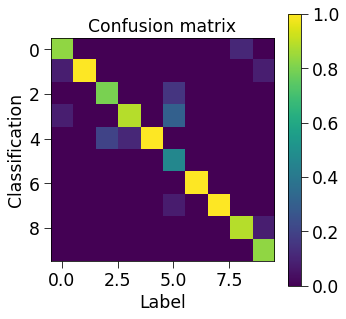

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

# Build confusion matrix
confusion = np.zeros((10, 10), dtype=int)
for l, c in zip(labels, classifications):
    confusion[c, l] += 1

# Normalize columns
col_sum = np.sum(confusion, axis=0)
confusion = confusion / col_sum
    
# Show confusion matrix
plt.figure(figsize=(5, 5))
plt.imshow(confusion)
plt.colorbar()
plt.xlabel("Label")
plt.ylabel("Classification")
_ = plt.title("Confusion matrix")

### Disconnect to release board

In [30]:
model.disconnect()

## 5. Performance analysis

### Runtime/accuracy trade off
Here, we instantiate the above network but classify the test set by presenting the input samples for increasing number ot time steps per sample. This allows us to measure the dependency of the accuracy as a function of runtime.

In [31]:
def build_and_run(x_test, y_test, num_steps_per_sample, reset_mode, probe_energy=False, bin_size=None, buffer_size=4096):
    """Builds SNN from file, creates energy probe and executes model for specified number of steps per sample.
    
    :param np.array x_test: Test set.
    :param np.array y_test: Test labels.
    :param int num_steps_per_sample: Number of time steps each sample is presented to the network.
    :param string reset_mode: 'soft' or 'hard' selects between reset by subtraction or reset to zero.
    :param bool probe_energy: Enables or disables energy probe creation.
    :param int bin_size: Number of time steps to averagein EnergyProbe/ExecutionTime probe. Defaults to num_steps_per_sample.
    
    :returns: (boot time, input injection time, classification time), classifications, labels, energy probe
    """
    model = build_snn_from_file(snntb_log_dir=MODEL_NAME+"_"+reset_mode,
                                num_steps_per_img=num_steps_per_sample)

    eProbe = None
    if probe_energy:
        from nxsdk.api.enums.api_enums import ProbeParameter
        from nxsdk.graph.monitor.probes import PerformanceProbeCondition
        
        if bin_size is None:
            bin_size = num_steps_per_sample
        eProbe = model.board.probe(
            probeType=ProbeParameter.ENERGY,
            probeCondition=PerformanceProbeCondition(
                tStart=1,
                tEnd=len(y_test)*num_steps_per_sample,
                bufferSize=buffer_size,
                binSize=bin_size))
    
    
    (dt_boot, dt_input, dt_classification), classifications, labels = run_model(
        model, num_steps_per_sample, x_test, y_test)
    
    model.disconnect()
    
    return (dt_boot, dt_input, dt_classification), classifications, labels, eProbe

In [32]:
import time

# Select specific board for reproducible results
#os.environ["PARTITION"] = "nahuku32"
#os.environ["BOARD"] = "ncl-ghrd-06"

# Select random subset of test data
np.random.seed(0)
num_test_samples = 1000
idx = np.random.choice(len(y_test), num_test_samples, replace=False)

# Specifies for which number or time steps per sample to measure accuracy
num_steps_per_samples = [64, 128, 256, 512, 1024, 2048]

# Measure classification accuracy for different numbers of time steps per sample
dt_classification = []
accuracies = []
tStart = time.time()
for nsps in num_steps_per_samples:
    (_, _, dt_c), c, l, _ = build_and_run(x_test[idx, :, :], y_test[idx], nsps, reset_mode)
    dt_classification.append(dt_c)
    accuracies.append(calc_accuracy(c, l))
tEnd = time.time()

/homes/biagiom/python3_venv/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Sending images...spikes... . .. 
Waiting for classification to finish...


/homes/biagiom/python3_venv/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Sending images...spikes... . .. 
Waiting for classification to finish...


/homes/biagiom/python3_venv/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Sending images...spikes... . .. 
Waiting for classification to finish...


/homes/biagiom/python3_venv/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Sending images...spikes... . .. 
Waiting for classification to finish...


/homes/biagiom/python3_venv/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Sending images...spikes... . .. 
Waiting for classification to finish...


/homes/biagiom/python3_venv/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Sending images...spikes... . .  
Waiting for classification to finish...


In [40]:
print("Time to execute all runs for {} time steps per sample: {}s".format(num_steps_per_samples, int(tEnd-tStart)))

Time to execute all runs for [64, 128, 256, 512, 1024, 2048] time steps per sample: 1462s


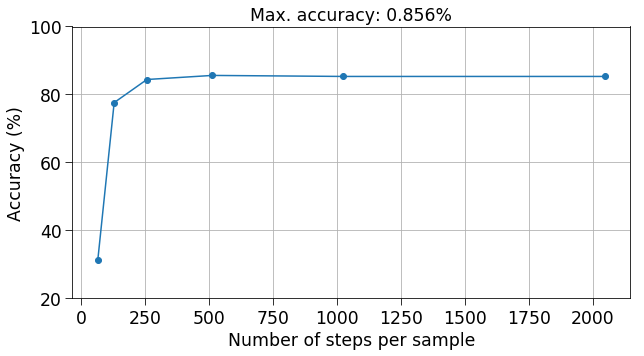

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(num_steps_per_samples, np.asarray(accuracies)*100, marker='.', markersize=12)
plt.grid(b=True, which='both', axis='both')
plt.ylim(20, 100)
plt.xlabel("Number of steps per sample")
plt.ylabel("Accuracy (%)")
_ = plt.title("Max. accuracy: {}%".format(max(accuracies*100)))

The accuracy improves with increaing number of time steps per sample and saturates around 512 time steps. This also allows to trade off accuracy versus runtime. More training epochs, considering weight and bias quantization during training or optimizing the ANN <-> SNN correlation post conversion should allow to improve the saturation accuracy.

### Execution time characterization
We can analyze the execution time characteristics of the SNN in more detail by instantiating energy probes that allow to measure power and execution time per time step.

To maximize temporal resolution, we set the bin_size of the energy probe to 1. For larger values, the execution times of subsequent time steps get averaged.

In [35]:
np.random.seed(0)
num_test_samples = 100
num_steps_per_sample = 512
buffer_size = 1024
idx = np.random.choice(len(y_test), num_test_samples, replace=False)
_, _, _, energy_probe = build_and_run(
    x_test[idx, :, :], y_test[idx], num_steps_per_sample, reset_mode, probe_energy=True, bin_size=1, buffer_size=1024)

/homes/biagiom/python3_venv/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Sending images...spikes... . .. 
Waiting for classification to finish...


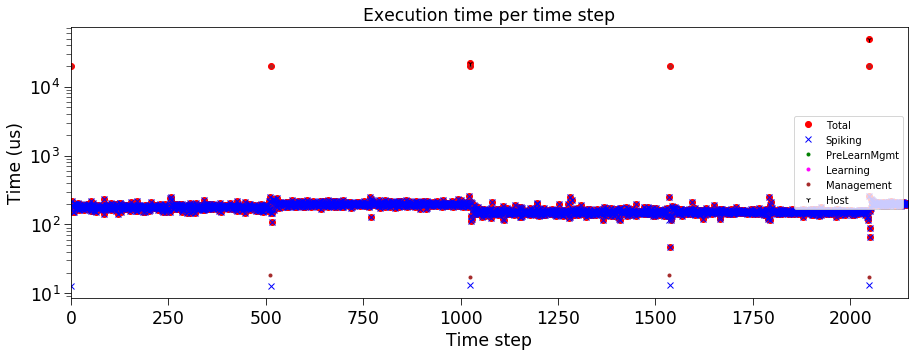

In [42]:
plt.figure(figsize=(15, 5))
energy_probe.plotExecutionTime()
plt.xlim(0, 2*buffer_size+100)
plt.gca().set_yscale('log')
_ = plt.legend(loc='right', fontsize=10)

Every time step consists of multiple phases (SPIKING, LEARNING, MANGEMENT, HOST). In this application, only SPIKING, MANAGEMENT and HOST are relevant. 

We observe that the execution time of the spiking phase is around 100-200us (depends on board and sample) per time step (blue crosses). At the end of each sample (multiple of 512), we read out the classification result via the membrane potentials of the output layer, reset the entire network (currents, membrane voltages) and inject the new input via bias currents into the input layer. 

The input injection via the InputGenerator leads to a noticable spike of the total time to around 10ms every multiple of 512 time steps. 
In addition, an artifact of probing the execution time is that the execution time buffer on the embedded CPU needs to be transferred to the host, whenever it is full. Since we set the buffer_size to 4096, this lead to a spike in the total time per time step to around 100ms at multiples of 4096.

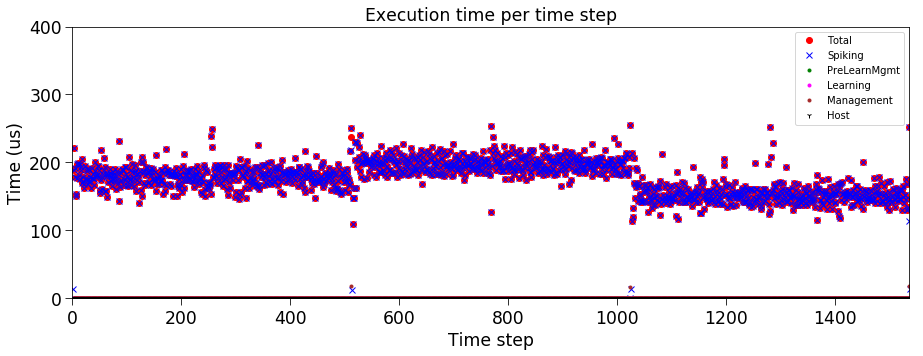

In [43]:
maxT = 400
plt.figure(figsize=(15, 5))
energy_probe.plotExecutionTime()
plt.xlim(0, 3*512)
plt.ylim(0, maxT)
_ = plt.legend(fontsize=10)

A closer look shows that the execution time per time steps varies slightly from sample to sample due to different levels of spiking activity for each sample.

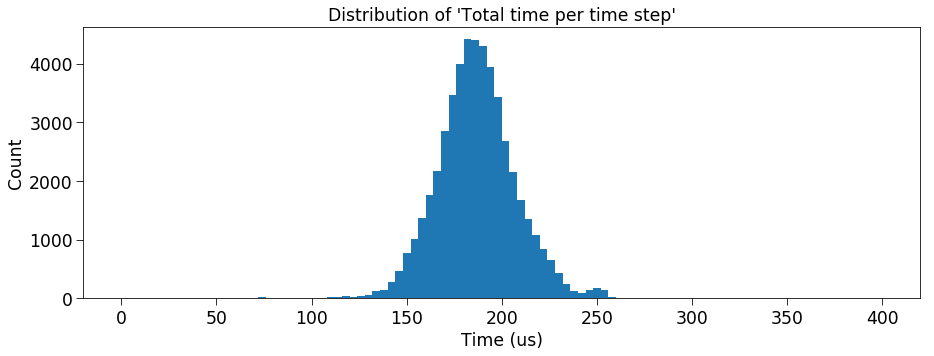

In [44]:
plt.figure(figsize=(15, 5))
_ = plt.hist(energy_probe.totalTimePerTimeStep, bins=100, range=(0, maxT))
plt.xlabel('Time (us)')
plt.ylabel('Count')
_ = plt.title("Distribution of 'Total time per time step'")

The histogram of execution time per time step shows that most samples lead to a time per time step on the order of 100us.

#### A note on power measurements
As illustrated in the above example, the execution time per time step can vary highly depending on whether the embedded CPU or host is involved or not. Since the Loihi board is only capable of measuring current and voltage on 30-40ms time scale, variations in power consumption on a time scale shorter than that cannot be reliably resolved. Thus the power repored by the EnergyProbe is only an average power over a rolling window of many milliseconds. Therefore, unless the power is truly stable, the energy reported per time step in the energy probe is meaningless and needs to be computed manually with an understanding of which parallel and sequential processes are active at the time of measurement.

Generally, the neuro cores consume most of the power, when active (as during the SPIKING phase). When neuro cores are inactive, as during read out or input injection, the system operates at the idle power level. Thus the average power measured as in the image classification example above, is roughly a time weighted average of the active power consumed by the neuro cores and the idle power present during IO. 

A power characterization of the above image classification example will follow...